In [33]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
import cv2 
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from skimage.filters import threshold_otsu
import seaborn as sns
from skimage.color import rgb2gray
from skimage.morphology import convex_hull_image
from scipy.spatial import ConvexHull
from skimage.measure import label, regionprops
from skimage.draw import polygon,rectangle,polygon_perimeter
import pandas as pd
from scipy.stats import f_oneway
from itertools import combinations
from scipy.stats import ttest_ind
from sklearn.linear_model import LinearRegression
from scipy.stats import ttest_1samp

In [24]:
import matplotlib.pyplot as plt

def ploty(x, y, size1=10, size2=1.5, interval=10, title="plotting", x_ticks_positions=90):
    """
    Function to plot x vs. y with customizable figure size, x-tick positions, and axis labels.
    
    Parameters:
    - x: x-axis data
    - y: y-axis data
    - size1: Width of the plot
    - size2: Height of the plot
    - interval: Interval for x-tick positions
    - title: Title of the plot
    - x_ticks_positions: Rotation angle for x-axis labels
    """
    # Create a single plot
    plt.figure(figsize=(size1, size2*2))
    
    # Plot the data
    plt.plot(x, y)
    total_data_points = len(x)
    interval = total_data_points // interval
    x_ticks = x[::interval]  # Calculate positions for x-ticks
    plt.xticks(ticks=x_ticks, rotation=x_ticks_positions)  # Rotate x-axis labels
    
    # Add labels, legend, and title
    if hasattr(y, 'columns'):  # Check if y has column names
        plt.legend(y.columns)
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title(title)
    plt.grid()
    
    # Show the plot
    plt.tight_layout()
    plt.show()

# Example usage
# Assuming x and y are defined:
# ploty(x, y)

In [7]:
dataset1 = pd.read_csv(r'..\data_3\LSTM.csv')  # Replace with actual path
dataset2 = pd.read_csv(r'..\data_3\RNN.csv')  # Replace with actual path

In [8]:
year=dataset1['Year']

In [9]:
# Strip off the 'year' column from both prediction datasets (if it's present)
dataset1 = dataset1.drop(columns=['Year'], errors='ignore')  # Handle if 'year' is missing
dataset2 = dataset2.drop(columns=['Year'], errors='ignore')  # Handle if 'year' is missing

In [10]:
# Example RMSE values
rmse_model1 = 0.32449987530708313
rmse_model2 = 0.2156643122434616

# Calculate inverse RMSE
inv_rmse_model1 = 1 / rmse_model1
inv_rmse_model2 = 1 / rmse_model2

# Calculate total inverse RMSE
total_inv_rmse = inv_rmse_model1 + inv_rmse_model2

# Calculate weights
weight1 = inv_rmse_model1 / total_inv_rmse
weight2 = inv_rmse_model2 / total_inv_rmse

print(f"Weight for model1: {weight1}")
print(f"Weight for model2: {weight2}")

Weight for model1: 0.3992569615202068
Weight for model2: 0.6007430384797933


In [11]:
# Weighted Averaging
pred = (weight1 * dataset1 + weight2 * dataset2) / (weight1 + weight2)

In [17]:
pred.describe().T.drop(["25%"	,"50%"	,"75%",'count'],axis=1)

,mean,std,min,max
Feature1,0.123809,0.008339,0.115287,0.139104
Feature2,87618.157067,2898.339236,84676.101481,92881.988214
Feature3,84590.430510,2543.395444,81909.957370,88949.836907
Feature4,1168.865602,10.508280,1150.825957,1193.124054
Feature5,430.980247,13.150189,414.439897,456.342187
Feature6,1086.487443,6.616892,1075.587143,1102.500300
Feature7,0.775847,0.006736,0.763532,0.784915
Feature8,0.145037,0.010886,0.134262,0.164506


In [22]:
from scipy.stats import f_oneway

l:list = ['Feature1', 'Feature2', 'Feature3', 'Feature4', 'Feature5', 'Feature6',
        'Feature8']
# Perform one-way ANOVA across all features
f_stat, p_value = f_oneway(*[pred[col].values for col in l])

# Display results
print(f"F-Statistic: {f_stat:.2f}")
print(f"P-Value: {p_value:.4f}")

# Interpretation
alpha = 0.05
if p_value < alpha:
    print("Significant differences exist between the features.")
else:
    print("No significant differences between the features.")

F-Statistic: 32844.81
P-Value: 0.0000
Significant differences exist between the features.


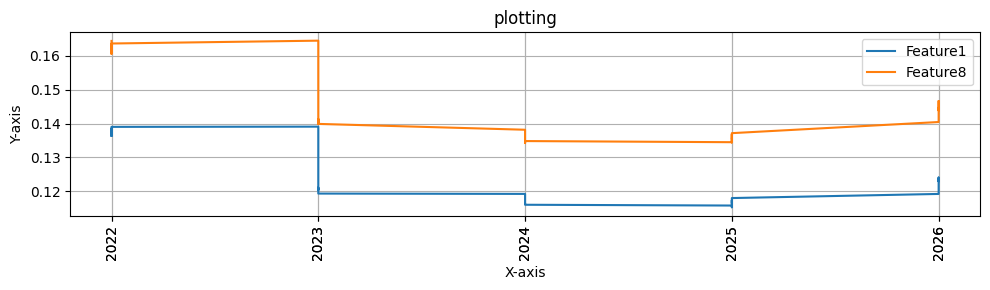

In [26]:
ploty(year,pred[["Feature1","Feature8"]], interval=10)

In [28]:
# Calculate year-over-year differences for features
pred['Feature1_change'] = pred['Feature1'].diff()
pred['Feature8_change'] = pred['Feature8'].diff()
pred['Year']=year
# Filter data for 2012 to 2019 and 2019 to 2021

from_2022_to_2026 = pred[(pred['Year'] >= 2022) & (pred['Year'] <= 2026)]

# Calculate average annual rate of change for both periods
from_avg_change_f1 = from_2022_to_2026['Feature1_change'].mean()

from_avg_change_f8 = from_2022_to_2026['Feature8_change'].mean()

# Display the results
print("Feature1 - Average Annual Rate of Change:")
print(f"2022-2026: {from_avg_change_f1:.4f}\n")

print("Feature8 - Average Annual Rate of Change:")
print(f"2022-2026: {from_avg_change_f8:.4f}")

Feature1 - Average Annual Rate of Change:
2022-2026: -0.0004

Feature8 - Average Annual Rate of Change:
2022-2026: -0.0005


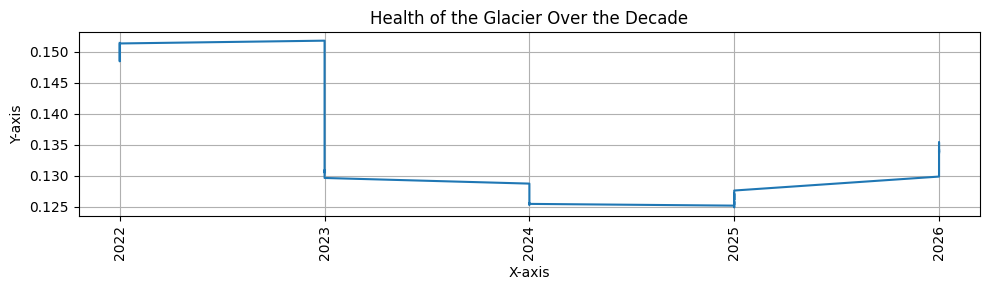

In [32]:
l1=list(pred['Feature1'])

l2=list(pred['Feature8'])


health=list(map(lambda x,y: (x+y)/2, l1,l2))
ploty(pred['Year'],health,interval=5,size2=1.5,size1=10,title="Health of the Glacier Over the Decade")

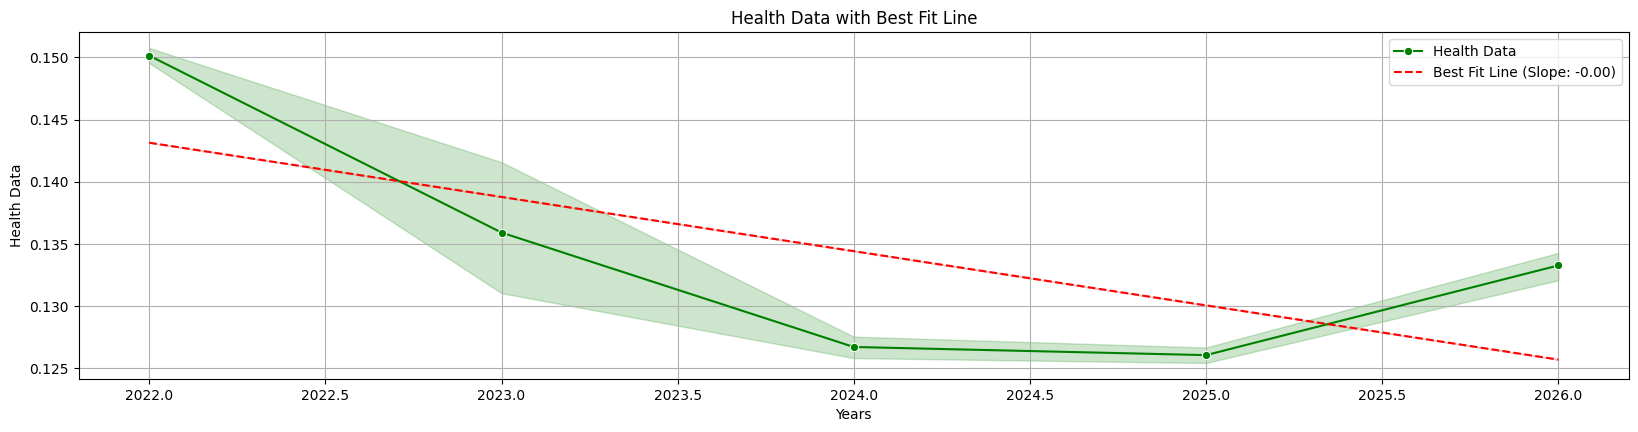

Calculated Slope (Rate of Change): -0.0044


In [49]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Assuming 'pred' is a DataFrame containing 'Year' and 'health' is the health data
# Example data (replace with actual data)
# pred['Year'] is the years (e.g., 1986, 1987, etc.)
# health is the health data corresponding to those years
years = pred['Year'].values.reshape(-1, 1)  # Reshaping to 2D array for the model
health = health  # Your health data corresponding to years

# Initialize and fit the model
reg = LinearRegression()
reg.fit(years, health)

# Get the slope (rate of change)
slope = reg.coef_[0]

# Calculate the best-fit line
best_fit_line = reg.predict(years)  # Predicting using the same 'years' data

# Create the plot with seaborn
plt.figure(figsize=(20, 4.5))

# Plot the Health Data
sns.lineplot(x=pred['Year'], y=health, label='Health Data', marker='o', color='green')

# Plot the Best Fit Line (use the same data)
sns.lineplot(x=pred['Year'], y=best_fit_line, label=f'Best Fit Line (Slope: {slope:.2f})', color='red', linestyle='--')

# Customize the plot
plt.xlabel('Years')
plt.ylabel('Health Data')
plt.title('Health Data with Best Fit Line')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()
# Display the calculated slope
print(f"Calculated Slope (Rate of Change): {slope:.4f}")


In [50]:
pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Feature1         40 non-null     float64
 1   Feature2         40 non-null     float64
 2   Feature3         40 non-null     float64
 3   Feature4         40 non-null     float64
 4   Feature5         40 non-null     float64
 5   Feature6         40 non-null     float64
 6   Feature7         40 non-null     float64
 7   Feature8         40 non-null     float64
 8   Feature1_change  39 non-null     float64
 9   Feature8_change  39 non-null     float64
 10  Year             40 non-null     int64  
 11  Period           40 non-null     object 
dtypes: float64(10), int64(1), object(1)
memory usage: 3.9+ KB


In [52]:
pred.drop(['Feature1_change','Feature8_change','Period'],axis=1,inplace=True)

In [53]:
pred.to_csv(r"../data_3/ensemble.csv", index=False)